    Host Id Host Since                                Name Neighbourhood   \
0   5162530        NaN     1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN     Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN                Sunny Room in Harlem      Manhattan   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony      Manhattan   
4       500  6/26/2008            Trendy Times Square Loft      Manhattan   

  Property Type  Review Scores Rating (bin)        Room Type  Zipcode  Beds  \
0     Apartment                         NaN  Entire home/apt  11249.0   1.0   
1     Apartment                         NaN     Private room  11206.0   1.0   
2     Apartment                         NaN     Private room  10032.0   1.0   
3     Apartment                         NaN  Entire home/apt  10024.0   3.0   
4     Apartment                        95.0     Private room  10036.0   3.0   

   Number of Records  Number Of Reviews Price  Review Scores R

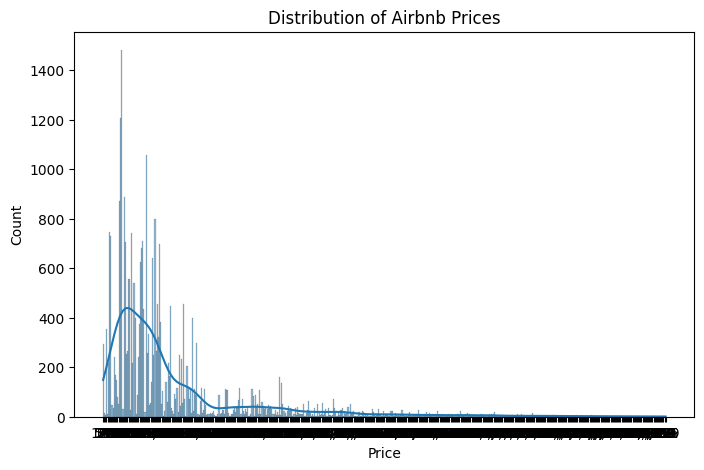

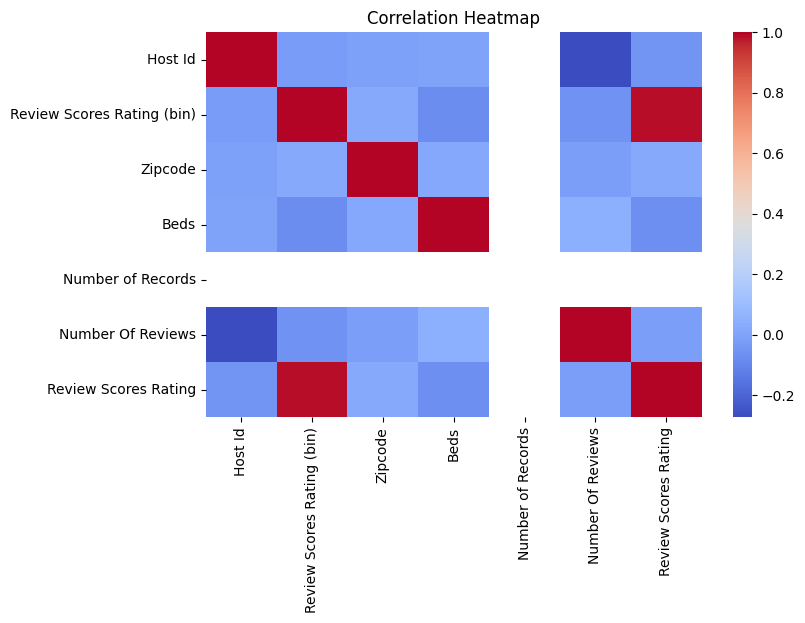

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load Data
df = pd.read_csv("data/airbnb_hw.csv")

# Overview of Data (EDA)
print(df.head())
print(df.info())
print(df.describe())

plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [6]:
print(df.isnull().sum())

# 3. CLEANING AND FEATURE ENGINEERING

# Drop columns not needed for modeling
df = df.drop(columns=['Host Id', 'Name', 'Review Scores Rating (bin)'], errors='ignore')

# Handle missing values
df['Host Since'] = pd.to_datetime(df['Host Since'], errors='coerce')
df['Host Since'] = df['Host Since'].fillna(df['Host Since'].median())

df['Property Type'] = df['Property Type'].fillna(df['Property Type'].mode()[0])
df['Zipcode'] = df['Zipcode'].fillna(df['Zipcode'].mode()[0])
df['Beds'] = df['Beds'].fillna(df['Beds'].median())
df['Review Scores Rating'] = df['Review Scores Rating'].fillna(df['Review Scores Rating'].median())

# Create a derived variable: Host tenure (years)
df['Host Tenure (years)'] = (pd.Timestamp('today') - df['Host Since']).dt.days / 365
df['Host Tenure (years)'] = df['Host Tenure (years)'].fillna(df['Host Tenure (years)'].median())


Host Id                          0
Host Since                       3
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64


In [7]:
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns to encode:", cat_cols.tolist())

# One-hot encode all categorical variables (keep all categories)
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

print("Shape after encoding:", df.shape)

Categorical columns to encode: ['Neighbourhood ', 'Property Type', 'Room Type', 'Price']
Shape after encoding: (30478, 545)


In [25]:
# 3. TRAIN-TEST SPLIT

# Define target (y) and predictors (X)
x = df.drop(columns=['Price'])
y = df['Price']

# Split the data: 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42
)

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (24382, 12)
Test set shape: (6096, 12)


In [34]:
# 4. SIMPLE LINEAR MODELS

df = df.copy()
df["Price"] = pd.to_numeric(df["Price"].astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
df = df[df["Price"].notna()].reset_index(drop=True)

# 2) Keep only numeric predictors
x_all = df.drop(columns=["Price"]).select_dtypes(include="number").replace([np.inf, -np.inf], np.nan)
x_all = X_all.fillna(X_all.median(numeric_only=True))
y_all = df["Price"]

# 3) Split (80/20)
x_train, Xxtest, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

# 4) Choose three predictors (top |corr| with Price on TRAIN only)
corr = pd.concat([y_train, x_train], axis=1).corr(numeric_only=True)["Price"].drop("Price").abs()
predictors = corr.sort_values(ascending=False).head(3).index.tolist()
print("Using predictors:", predictors)

# 5) Fit three simple linear models and report metrics
rows = []
for col in predictors:
    model = LinearRegression().fit(x_train[[col]], y_train)
    y_tr = model.predict(x_train[[col]])
    y_te = model.predict(x_test[[col]])

    rows.append({
        "Predictor": col,
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_tr)),
        "Test RMSE":  np.sqrt(mean_squared_error(y_test,  y_te)),
        "Train R2":   r2_score(y_train, y_tr),
        "Test R2":    r2_score(y_test,  y_te)
    })

results = pd.DataFrame(rows)
print("\n=== Simple One-Predictor Linear Models ===")
print(results)

Using predictors: ['Beds', 'Zipcode', 'Review Scores Rating']

=== Simple One-Predictor Linear Models ===
              Predictor  Train RMSE   Test RMSE  Train R2   Test R2
0                  Beds  186.699916  192.029783  0.093248  0.118131
1               Zipcode  194.860308  202.505513  0.012250  0.019290
2  Review Scores Rating  195.865873  204.211315  0.002030  0.002699


The model using Beds as the predictor performs the best. It has the lowest RMSE and the highest R2 on both the training and test sets. This means the number of beds explains Airbnb price variation better than Zipcode or Review Scores Rating.

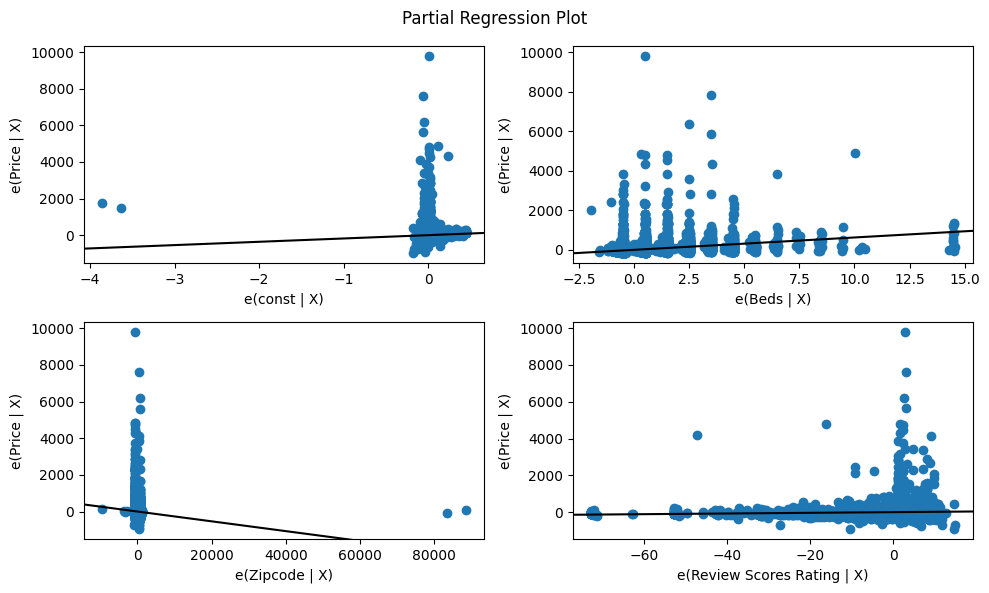

In [36]:
# 5. PARTIAL CORRELATION PLOTS

import statsmodels.api as sm

# Combine predictors and target
x = x_all[predictors]
y = y_all

# Add constant for intercept
x_const = sm.add_constant(x)

# Fit the full model (all three numeric variables)
model = sm.OLS(y, x_const).fit()

# Partial regression plots
fig = sm.graphics.plot_partregress_grid(model, fig=plt.figure(figsize=(10, 6)))
plt.tight_layout()
plt.show()


The partial regression plots reveal that none of the predictors have a strong linear relationship with price. Beds shows a mild positive association, but the spread of points and outliers suggest some non-linearity. Zipcode and Review Scores Rating display mostly scattered patterns, indicating that their effects on price are weak and not well captured by a simple linear model.